### Notebook to generate plots for different solvers

In [200]:
import numpy as np
import matplotlib.pyplot as plt
import clustering as cl
import util
import healpy as hp
import importlib as imp
from collections import defaultdict
import seaborn as sns 
sns.set_context('paper')
from time import time
import visual

%matplotlib inline 

In [65]:
# Global parameters
gs = [0.4]
gdots = np.linspace(-0.004, 0.004, 5) 
g_gdots = [(x,y) for x in gs for y in gdots]

nside=8
n = -14
dt=15.0
cr=0.00124
pixels=range(hp.nside2npix(nside))

train_path = 'demo_train/UnnObs_Training_1_line_A_ec_labelled_2457308.5_pm15.0_r2.5.trans'
itf_path = 'demo_itf/itf_new_1_line_ec_2457308.5_pm15.0_r2.5.trans'

In [66]:
tr_results, tr_clust_ids = cl.find_clusters([281], train_path, util.lunation_center(n), g_gdots=g_gdots,dt=dt,rad=cr)

Starting run...
100%

Run finished!


In [60]:
res_dict = cl.get_res_dict(train_path,[281],nside,n)[281]

In [72]:
agg_dict = defaultdict(list)
for k,v in tr_clust_ids.items():
    # k is the tracklet id, v is the cluster id 
    if res_dict[k]!=[]:
        agg_dict[v].append([tuple([k]+list(i)) for i in res_dict[k]])

# Generate plot: convergence of different solvers given different gdot densities

1.0
1425, 1
17: 1.5148514851485149


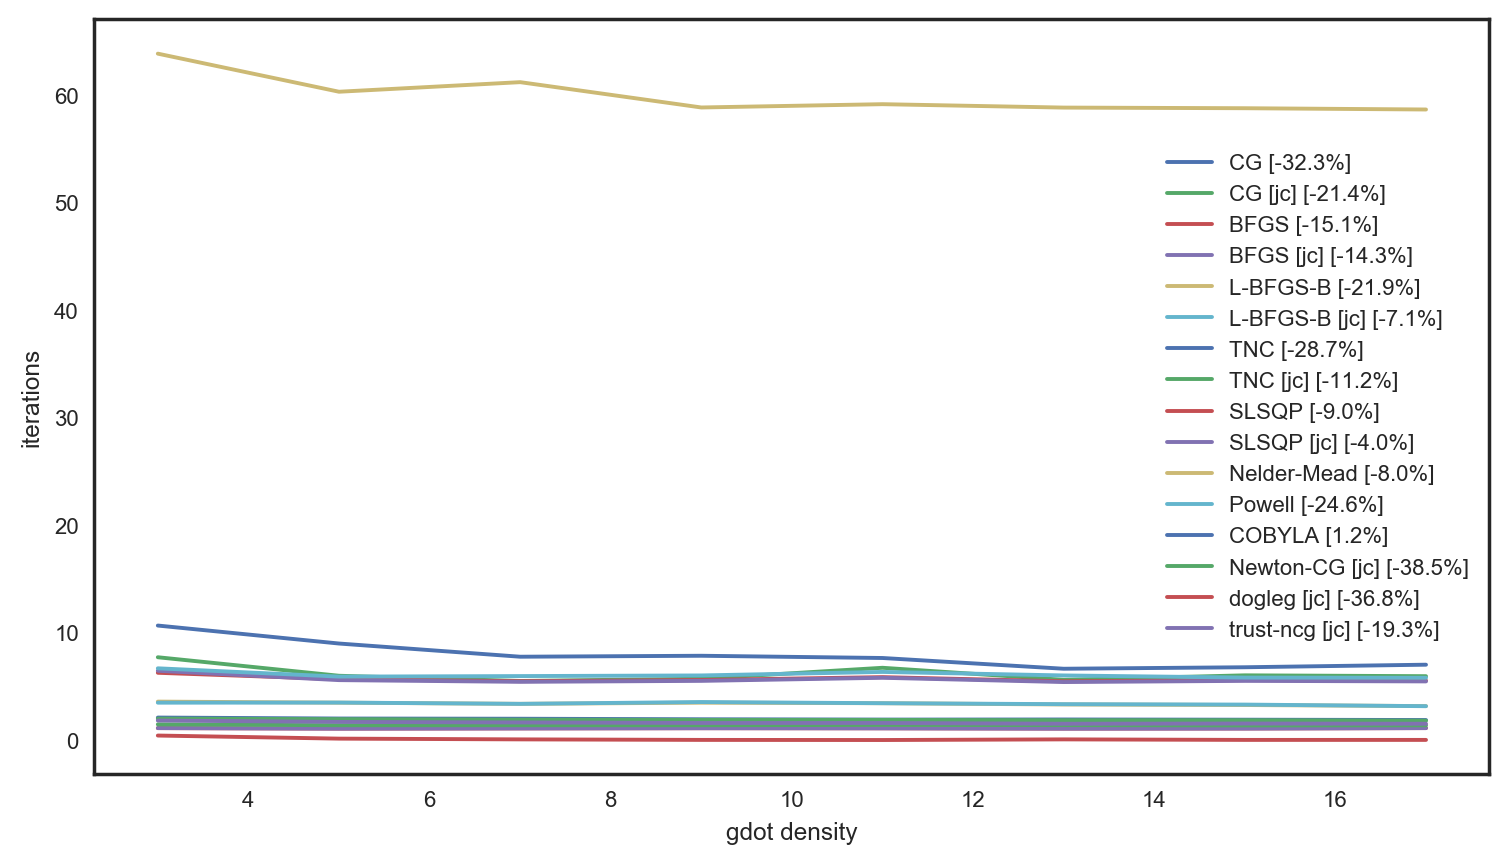

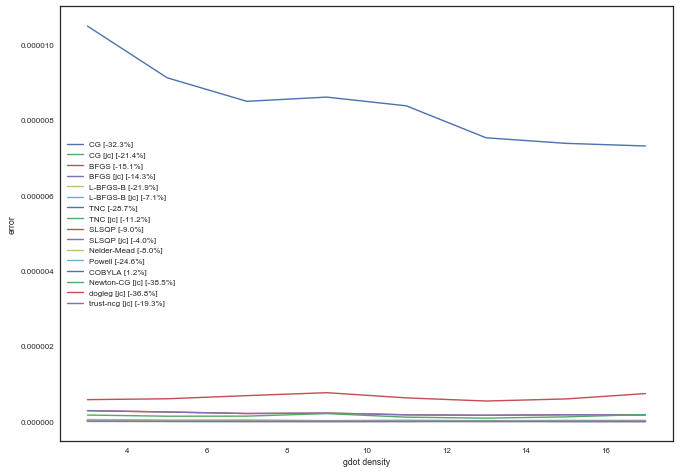

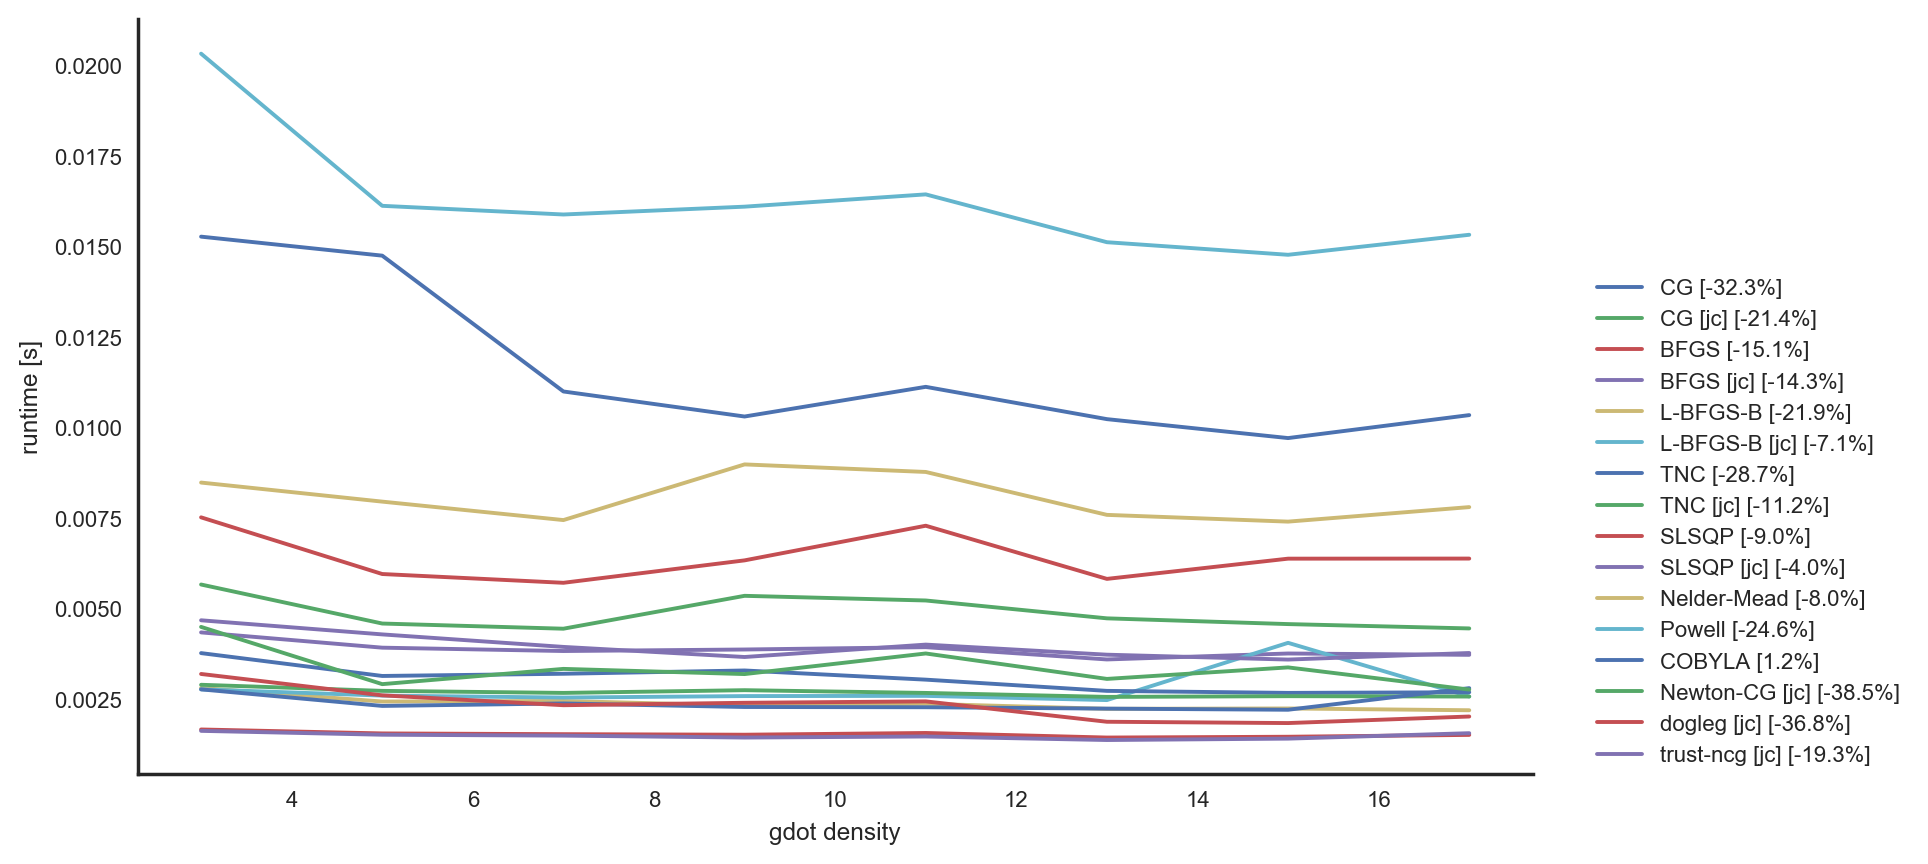

In [206]:
g,gdot = 0.4,0.0
cl = imp.reload(cl)
import time
from IPython.display import clear_output
sns.set_context('paper')
sns.set_style('white')

solvers = ['CG','BFGS','L-BFGS-B','TNC','SLSQP','Nelder-Mead','Powell','COBYLA','Newton-CG','dogleg','trust-ncg'] 
overall_means_iter = []
overall_means_acc = []
overall_means_runtime = []
#maximum number of clusters to re-fit
test_num = 100 

plt.figure(1, figsize = (9,5), dpi=200)
plt.figure(2, figsize = (11,8))
plt.figure(3, figsize = (9,5), dpi=200)

ktest_vals = range(3,18,2) #depth for gdot
legend=[]

for solver in solvers:
    print('running ' + solver)

    for use_jc in [False,True]:
        if use_jc and (solver=='Nelder-Mead' or solver=='Powell' or solver=='COBYLA'): continue #these solvers can not make use of the jacobian
        if not use_jc and (solver=='dogleg' or solver=='trust-ncg' or solver=='Newton-CG'): continue #these solvers explicitly require jacobians, so skip those
        
        yvals = []
        yvals_err = []
        yvals_runtime = []
        
        for ktest in ktest_vals:
            gdots = np.linspace(-0.004, 0.004, ktest) 
            g_gdots = [(x,y) for x in gs for y in gdots]
            tr_results, tr_clust_ids = cl.find_clusters([281], train_path, util.lunation_center(n), g_gdots=g_gdots,dt=dt,rad=cr,silent=True)
            res_dict = cl.get_res_dict(train_path,[281],nside,n)[281]

            agg_dict = defaultdict(list)
            agg_dict = defaultdict(list)
            for k,v in tr_clust_ids.items():
                # k is the tracklet id, v is the cluster id 
                if res_dict[k]!=[]:
                    agg_dict[v].append([tuple([k]+list(i)) for i in res_dict[k]])

            print('done')
            processed=0
            iter_avg=0
            avg_loss=0
            avg_runtime=0
            for idx in agg_dict:
                if len(agg_dict[idx])==0: continue #skip this one

                processed+=1
                if processed>test_num:
                    break
                clear_output(True)
                print(processed/min(len(agg_dict),test_num))
                print(str(idx) + ', ' + str(len(agg_dict[idx])))

                start = time.clock()
                returns = cl.full_fit_t_loss(util.lunation_center(n), g, gdot, agg_dict[idx], method=solver, use_jacobian=use_jc, details=True)
                time_elapsed = time.clock()-start

                params = returns[0]
                loss_val = returns[1]
                chisq = returns[2]
                chisq_arr = returns[3]

                iters = returns[4]
                iter_avg+=iters
                avg_loss+=loss_val
                avg_runtime+=time_elapsed

            iter_avg/=processed
            avg_loss/=processed
            avg_runtime/=processed
            print(str(ktest) + ": " + str(iter_avg))
            yvals.append(iter_avg)
            yvals_err.append(avg_loss)
            yvals_runtime.append(avg_runtime)

        rel_time_diff = round(100*(yvals_runtime[len(yvals_runtime)-1]/yvals_runtime[0]-1),1)
        res = plt.figure(1)
        res = plt.plot(ktest_vals, yvals)
        res = plt.figure(2)
        res = plt.plot(ktest_vals, yvals_err)
        res = plt.figure(3)
        res = plt.plot(ktest_vals, yvals_runtime)
        overall_means_iter.append(np.array(yvals).mean())
        overall_means_acc.append(np.array(yvals_err).mean())
        overall_means_runtime.append(np.array(yvals_runtime).mean())
        legend.append(solver + (' [jc]' if use_jc else '') + ' [' + str(rel_time_diff) + '%]')
        
        
res = plt.figure(1)
res = plt.xlabel('gdot density')
res = plt.ylabel('iterations')
res = plt.legend(legend)
res = plt.figure(2)
res = plt.xlabel('gdot density')
res = plt.ylabel('error')
res = plt.legend(legend)
res = plt.figure(3)
res = plt.xlabel('gdot density')
res = plt.ylabel('runtime [s]')
res = plt.legend(legend, loc=(1.04,0))
sns.despine()
res = plt.savefig('gdot-iterations.png', format='png', bbox_inches='tight')

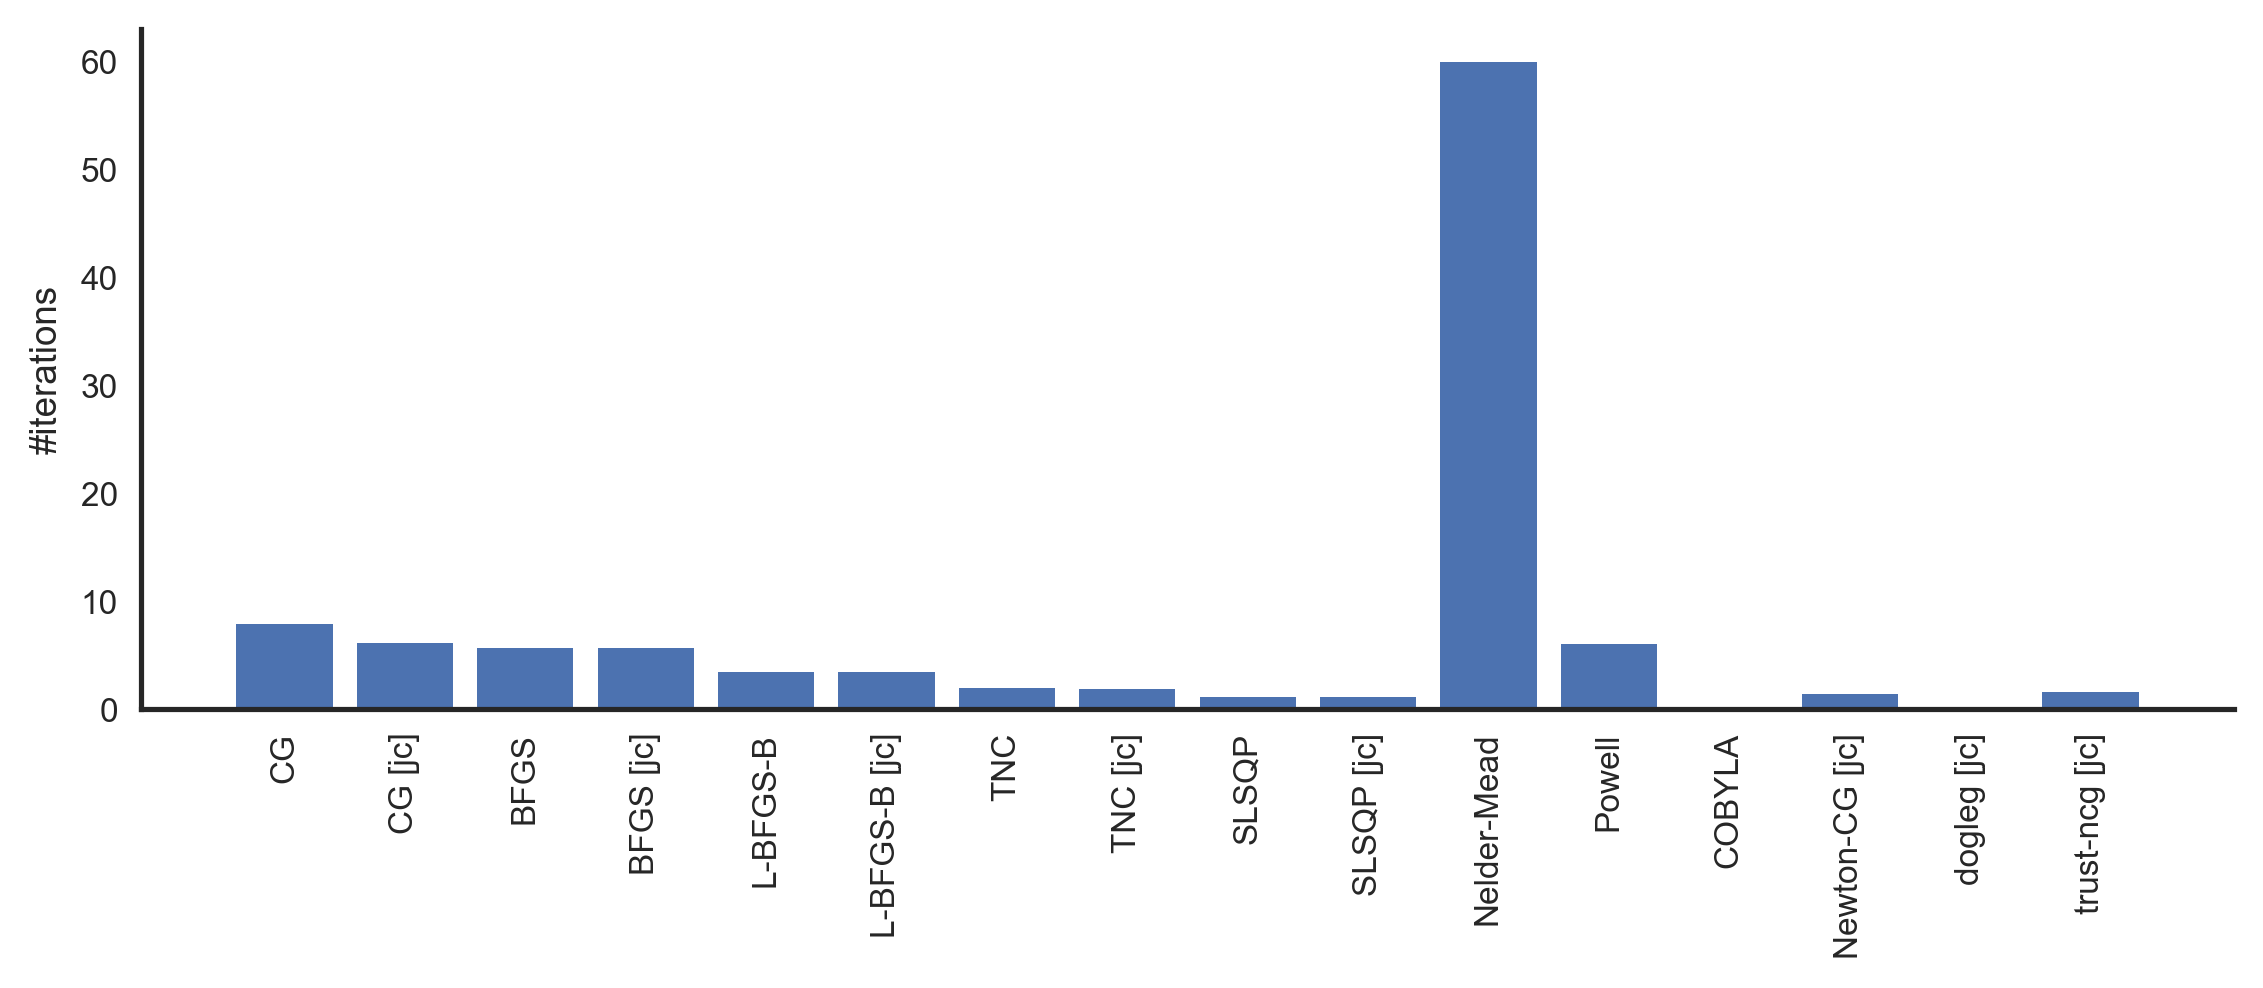

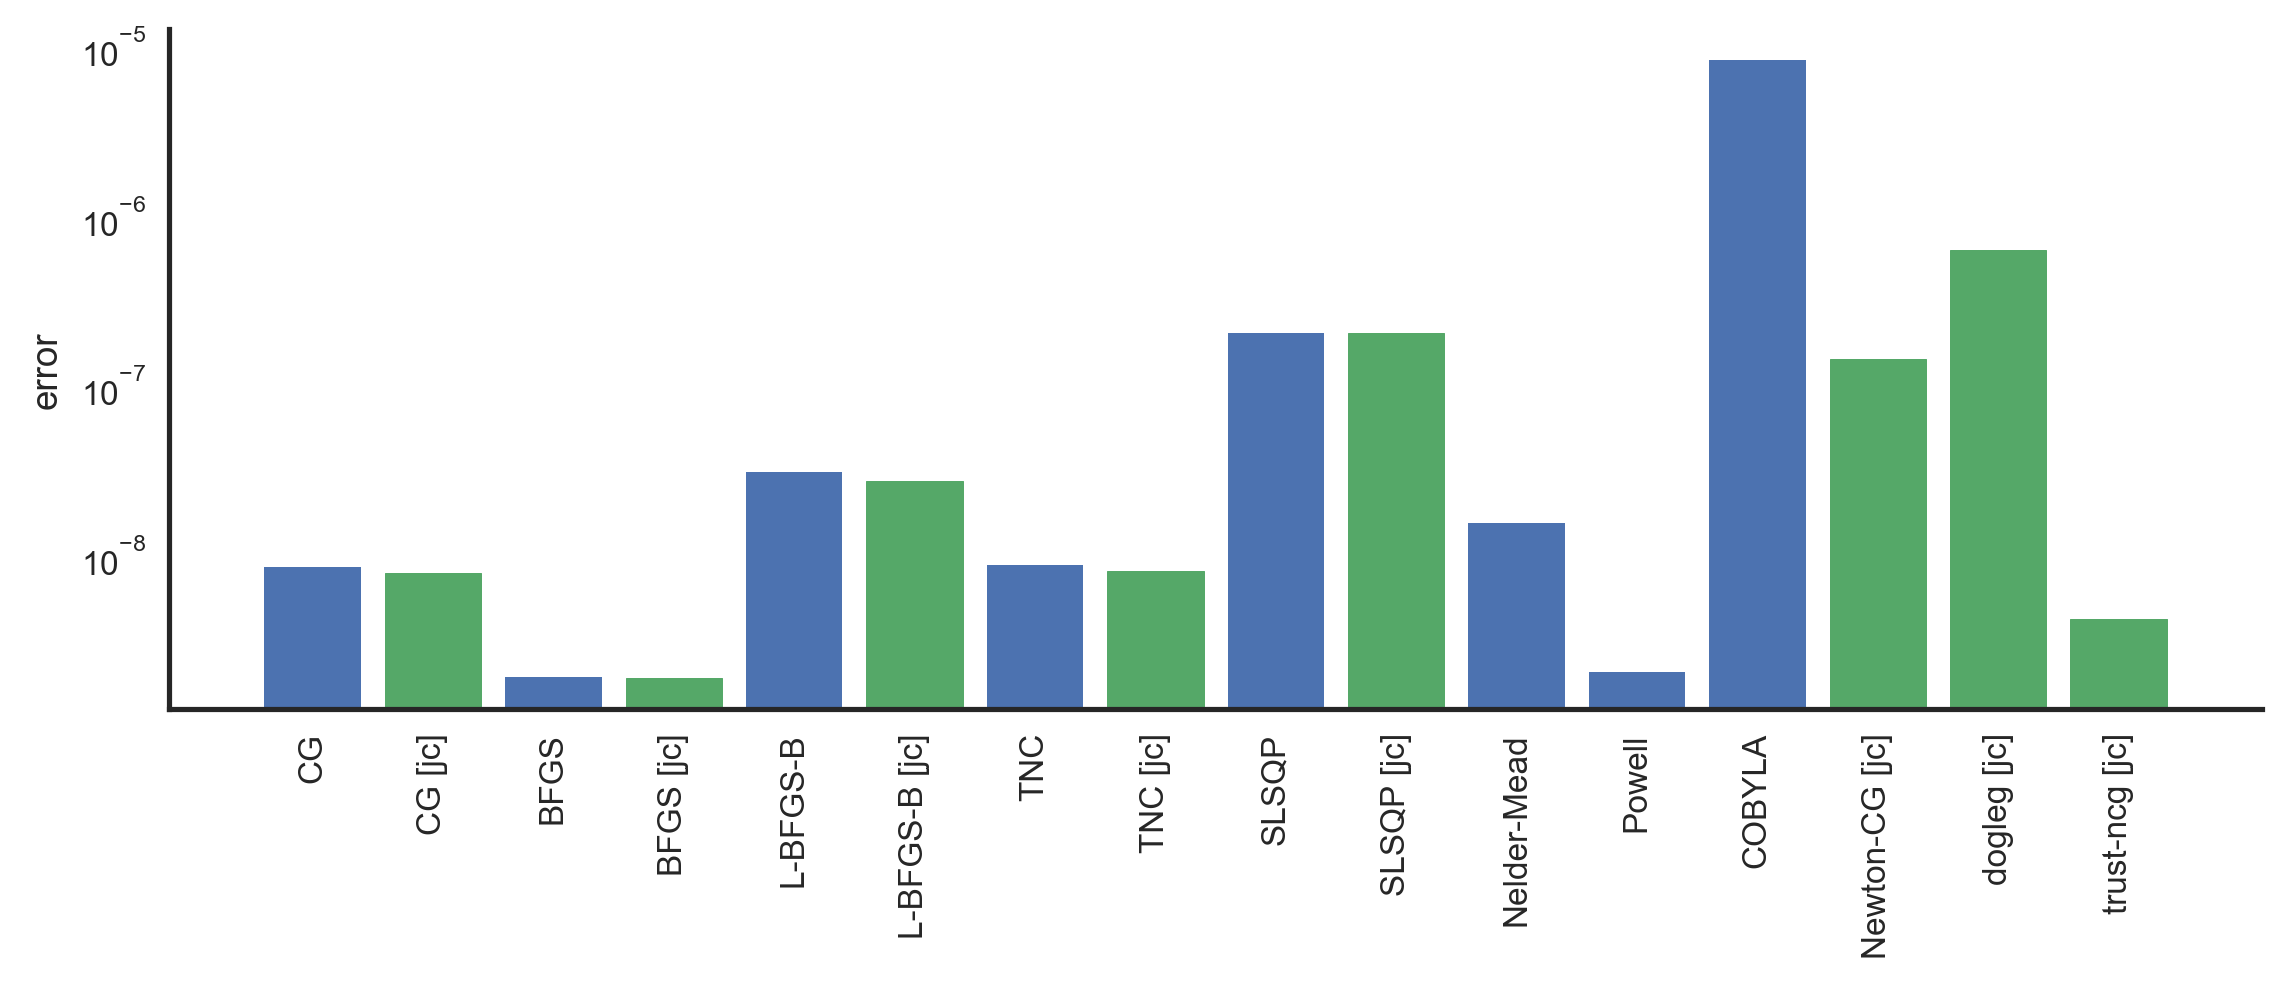

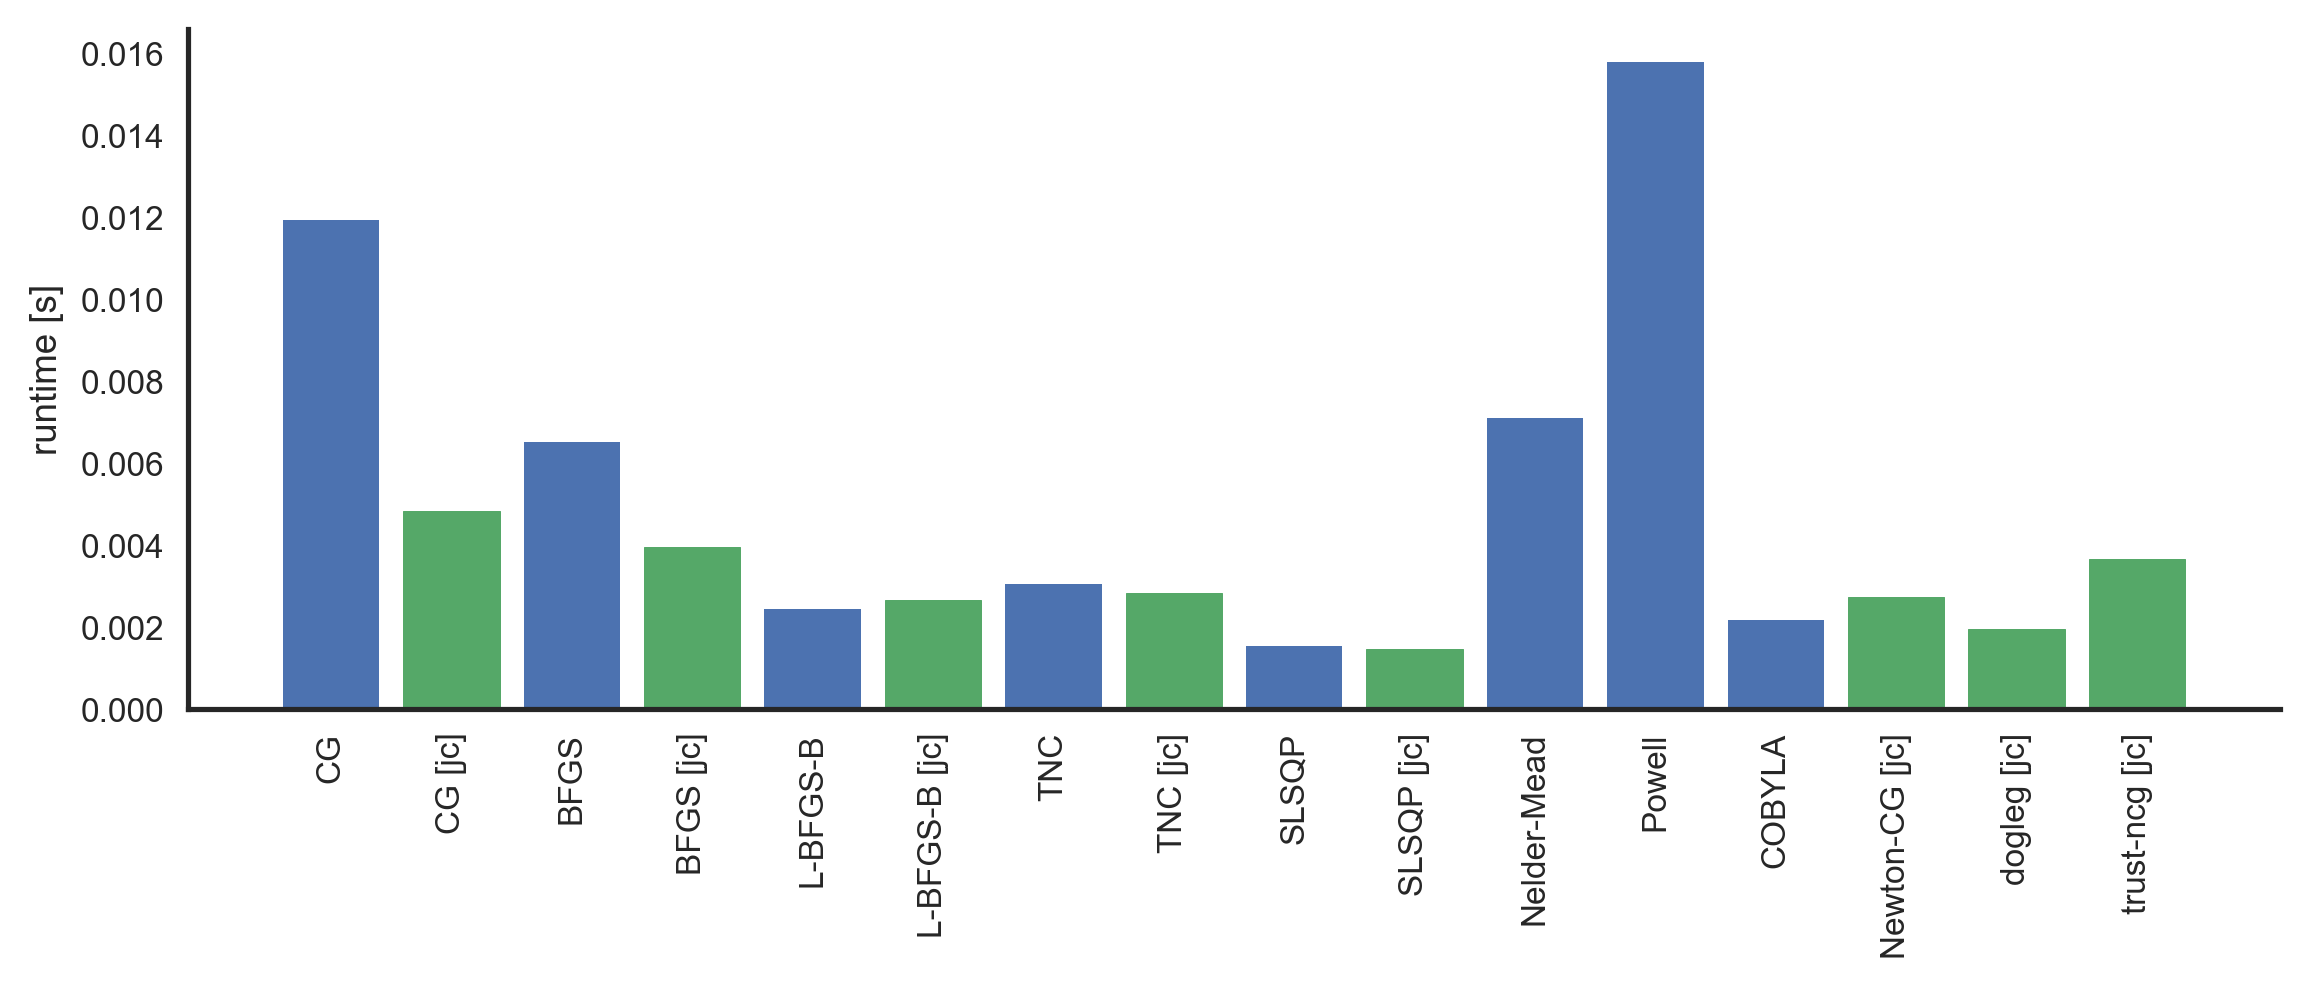

In [205]:
legend = ['CG','CG [jc]','BFGS','BFGS [jc]','L-BFGS-B','L-BFGS-B [jc]','TNC','TNC [jc]','SLSQP','SLSQP [jc]','Nelder-Mead','Powell','COBYLA','Newton-CG [jc]','dogleg [jc]','trust-ncg [jc]']

sns.set_context('paper')
sns.set_style('white')
current_palette = sns.color_palette()
indices = [1,3,5,7,9,13,14,15]

res = plt.figure(3, figsize=(9,3), dpi=300)
res = plt.bar(range(len(legend)), overall_means_iter)
res = plt.xticks(range(len(legend)), legend, rotation=90)
res = plt.ylabel('#iterations')
sns.despine()

res = plt.figure(4, figsize=(9,3), dpi=300)
res = plt.bar(range(len(legend)), overall_means_acc)
for ind in indices:
    res[ind].set_color(current_palette[1])
res = plt.xticks(range(len(legend)), legend, rotation=90)
res = plt.yscale('log')
res = plt.ylabel('error')
sns.despine()
res = plt.savefig('error_solvers.png', format='png', bbox_inches='tight')

res = plt.figure(5, figsize=(9,3), dpi=300)
res = plt.bar(range(len(legend)), overall_means_runtime)
for ind in indices:
    res[ind].set_color(current_palette[1])
res = plt.xticks(range(len(legend)), legend, rotation=90)
res = plt.ylabel('runtime [s]')
sns.despine()
res = plt.savefig('runtime_solvers.png', format='png', bbox_inches='tight')